In [1]:
# from matplotlib import pyplot as plt

# H = nx.gaussian_random_partition_graph(n=100,s=10,v=10,p_in=.25,p_out=.1)
# H = nx.relaxed_caveman_graph(l=3,k=15,p=0.15)
# H= nx.powerlaw_cluster_graph(n=200,m=10,p=0.2)
# H = nx.geographical_threshold_graph(200, 60)
# H = nx.karate_club_graph()
# H = nx.spectral_graph_forge(H,0.1)

# nx.draw(H)
# plt.figure(2,figsize=(20,20))
# nx.draw_spring(H,node_size=100,font_size=8) 
# plt.show()

In [2]:
# import pixiedust

In [1]:
# get the files from model.py
import math
from enum import Enum
import networkx as nx
from random import randrange

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid

from SimHelper import *

In [4]:
# x = generate_bias(0.5,1)
# y = generate_bias(0.5,1)
# z = random.random()/2
# print('user1',x,'user2',y)
# print(z)
# print('similarity',abs(x-y))
# print(abs(x-y)<z)

# Model

In [2]:
#### THIS CAN BE SUBSTITUTED WITH BIAS ##########
#Define the state of a new article
class State(Enum):
    NEUTRAL = 0
    SPAMMER = 1
#     RESISTANT = 2

In [3]:
def number_state(model, state):
    """
    GET THE TOTAL NUMBER OF PEOPLE FOR THE STATE YOU ARE LOOKING FOR
    
    sudo code
    for person in model.grid.get_all_cell_contents():
        if person.state is state:
            add 1 to the sum
    """
    return sum([1 for a in model.grid.get_all_cell_contents() if a.state is state])


def number_spammers(model):
    """
    use the number_state function to get back the total number of people who passed fake news
    """
    return number_state(model, State.SPAMMER)


def number_neutral(model):
    """
    use the number_state function to get back the total number of people who have not yet passed fake news
    """
    return number_state(model, State.NEUTRAL)

# def number_resistant(model):
#     """
#     use the number_state function to get back the total number of people RESISTANT to FAKE news
#     """
#     return number_state(model, State.RESISTANT)

def number_shares(model):
    return sum([1 for agent in model.grid.get_all_cell_contents() if agent.news is True])
#     return sum([1 for agent in model.schedule.agents if agent.news is not None])

def news_fake_status(model):
    return model.news.fake

def news_source(model):
    return model.news.source_id

In [4]:
class NewsArticle:
    """This is a news article that has a title sentiment and a number of shares"""
    def __init__(self,news_article_id,source_id,source_preference,sentiment,num_shares,fake):
        self.news_article_id = news_article_id
        self.source_id = source_id
        self.source_preference=source_preference
        self.sentiment=sentiment #value between (-5,-1) and (1,5)
        self.num_shares = num_shares # any value >=0
        self.fake=fake #either real=0 or fake=1

In [8]:
class User(Agent):
    # THIS COULD BE THE USER
    
    #CONSTRUCTOR -- REPLACE WITH USER ATTRIBUTES
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        fake_news_spread_chance,
        fake_news_check_frequency,
        recovery_chance,
        preference,
        news,
    ):
        super().__init__(unique_id, model)

        self.state = initial_state

        self.fake_news_spread_chance = fake_news_spread_chance
        self.fake_news_check_frequency = fake_news_check_frequency
        self.recovery_chance = recovery_chance
        self.preference = preference
        self.news= news

#     def try_to_spread_news(self):
#         # THE WHOLE THING IS RANDOM
#         neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
#         susceptible_neighbors = [
#             agent
#             for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
#             if agent.state is State.NEUTRAL
#         ]
#         for a in susceptible_neighbors:
#             if self.random.random() < self.fake_news_spread_chance:
#                 if self.random.random() < abs(self.preference - a.preference):
#                     a.state = State.SPAMMER
                    
    def try_to_spread_news(self):
        if not self.news:
            return
        else:
            neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
            susceptible_neighbors = [
                agent
                for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
                if not agent.news
            ]
            for a in susceptible_neighbors:
                #source credibility
                if self.random.random() < abs(self.preference - a.preference):
                    if abs(self.preference - self.model.news.source_preference) < 0.25:
                #sentiment
                        if self.model.news.sentiment/5 > random.random():
                #number of shares
                            shares_weight = self.model.news.num_shares/10
                            if shares_weight> 1:
                                shares_weight = 1
                            if generate_weighted_percentage(shares_weight):
                                a.news = True
                                if self.model.news.fake:
                                    a.state = State.SPAMMER
                        

    def try_fact_check(self):
        # Try to fact check
        if self.random.random() < self.recovery_chance:
            # Success
            self.state = State.NEUTRAL
#             self.try_gain_resistance()
        else:
            # Failed
            self.state = State.SPAMMER

#     def try_check_situation(self):
#         if self.random.random() < self.fake_news_check_frequency:
#             # Checking...
#             if self.state is State.SPAMMER:
#                 self.try_fact_check()
    
    def try_check_situation(self):
        if number_shares(self.model) > 90:
            self.state = State.NEUTRAL
            self.news = False

    def step(self):
        if self.model.news.source_id == self.unique_id:
            self.news = True
        if self.state is State.SPAMMER:
            self.try_to_spread_news()
#         self.try_check_situation()

(array([36., 11.,  4.,  0.,  0.,  2., 11., 11., 18.,  7.]),
 array([0.        , 0.00433333, 0.00866667, 0.013     , 0.01733333,
        0.02166667, 0.026     , 0.03033333, 0.03466667, 0.039     ,
        0.04333333]),
 <a list of 10 Patch objects>)

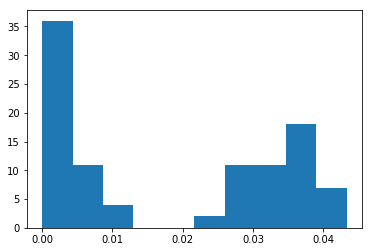

In [9]:
l= []
m = []
n=0
for i in range(100):
    diff = abs(generate_bias(0.5,1)-generate_bias(0.5,1))/30
    r = random.random() 
    l.append(diff)
    m.append(r)
    if r<diff:
        n += 1
plt.hist(l)

(array([20.,  9.,  8., 12., 10.,  7., 12.,  8.,  4., 10.]),
 array([0.00222533, 0.10025484, 0.19828434, 0.29631385, 0.39434336,
        0.49237287, 0.59040237, 0.68843188, 0.78646139, 0.8844909 ,
        0.9825204 ]),
 <a list of 10 Patch objects>)

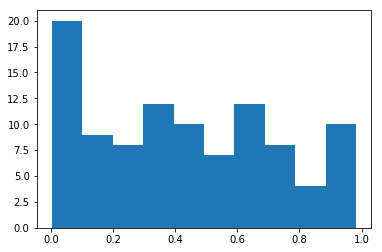

In [10]:
plt.hist(m)

In [11]:
# plt.hist(np.random.exponential(10,1000))

# plt.hist(np.random.normal(2.25, 0.4,1000))

In [12]:
 def make_news(model):
            #assign a news article
            source=randint(0,model.num_nodes-1)
            is_fake = generate_weighted_percentage(0.3)
            if is_fake:
                #make appropriate sentiment
                senti_score = round(np.random.normal(4.25, 0.3),2)
                if senti_score > 5:
                    senti_score = 5
                senti_score = senti_score*positive_or_negative()
                #make appropriate number of shares
                original_shares = int(np.random.exponential(10))
            else:
                #make appropriate sentiment
                senti_score = round(np.random.normal(2.25, 0.4),2)
                if senti_score > 5:
                    senti_score = 5
                elif senti_score < 1:
                    senti_score = 1
                senti_score = senti_score*positive_or_negative()
                #make appropriate number of shares
                original_shares = int(np.random.exponential(50))
            if not model.schedule.agents:
                preference = generate_preference()
            else:
                preference = model.schedule.agents[source].preference
                if preference > 1:
                    preference = 1
                elif preference < -1:
                    prefernece = -1
            news = NewsArticle(news_article_id=randint(0,1000),
                                    source_id=source, 
    #                                 source_preference=generate_preference(),
                                    source_preference=preference,
                                    sentiment=senti_score,
                                    num_shares= original_shares,
                                    fake=is_fake)
            return news

In [13]:
np.random.exponential(50)

49.019045482890874

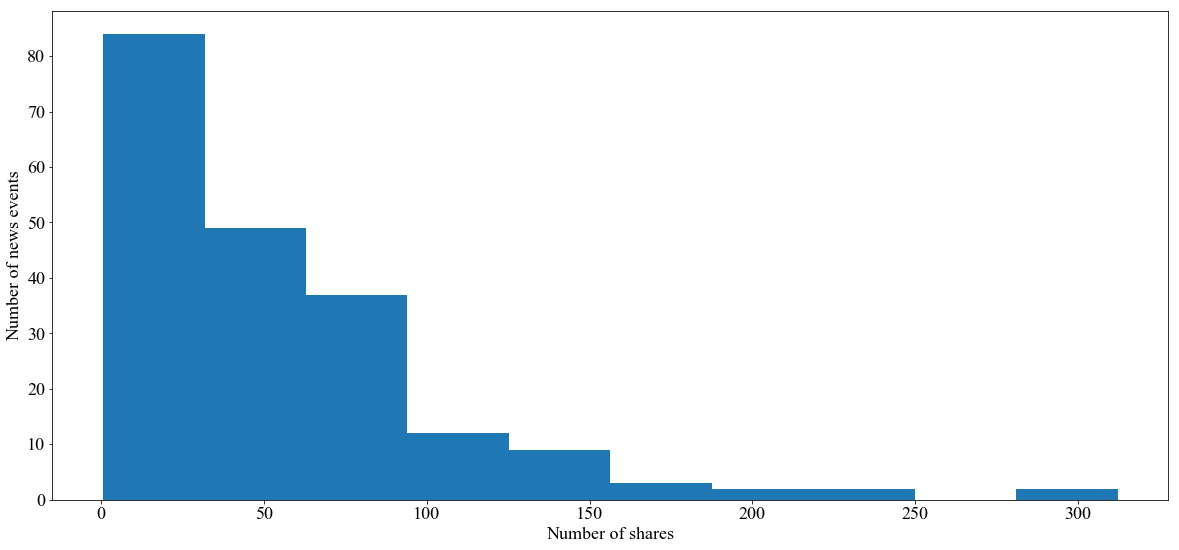

In [66]:
l = []
for i in range(200):
    l.append(np.random.exponential(50))
plt.hist(l)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

plt.xlabel('Number of shares')
plt.ylabel('Number of news events')
plt.savefig("test.png")
plt.show()

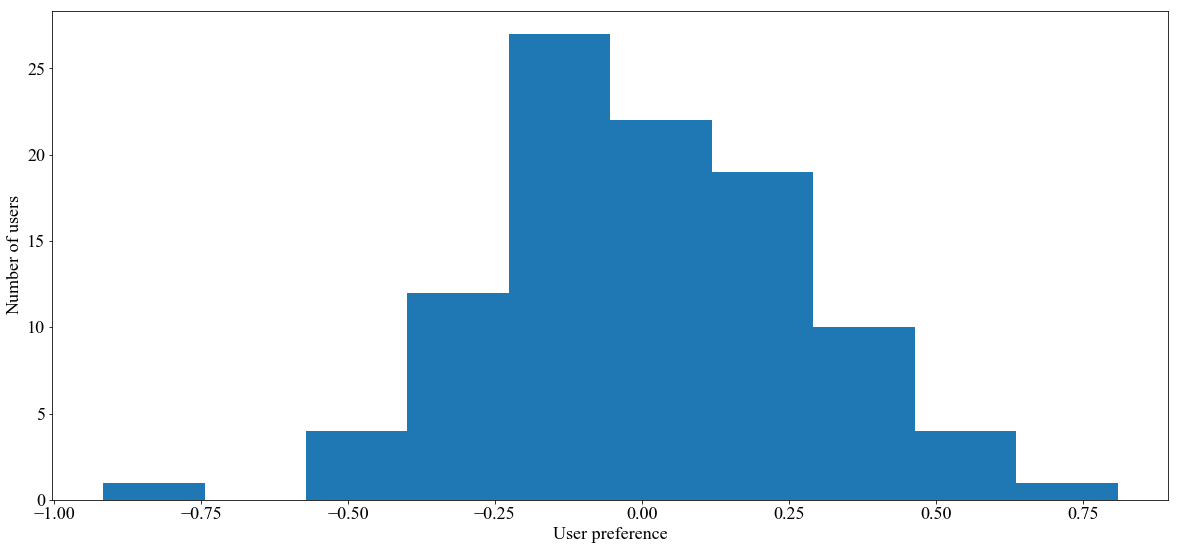

In [68]:
l = []
for i in range(100):
    l.append(generate_preference())
plt.hist(l)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.xlabel('User preference')
plt.ylabel('Number of users')
plt.savefig("test.png")
plt.show()

In [16]:
class SocialNetwork(Model):
    """A social network model with some number of agents"""
    
    """MODEL CONSTRUCTOR NEEDS AN __init__ method and step method"""
    def __init__(
        self,
        num_nodes=100,
        avg_node_degree=20,
        initial_outbreak_size=5,
        ##### think about changing the ones below ###############
        fake_news_spread_chance=0.8,
        fake_news_check_frequency=0.2,
        recovery_chance=0.3,
        news=None,
        #########################################################
    ):

        #INITIALIZE THE NETWORK, CHANGE HERE TO OTHER GRAPH TYPES
        self.num_nodes = num_nodes
        prob = avg_node_degree / self.num_nodes
#         self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
#         self.G = nx.geographical_threshold_graph(n=self.num_nodes,theta = prob*self.num_nodes)

        """
        Relaxed Caveman Graph allows to create small communities that are connected. Its parameters are:
        l (int) – Number of groups, which should be a fraction of num_nodes
        k (int) – Size of cliques
        p (float) – Probabilty of rewiring each edge.
        """
#         l = randrange(int(math.log1p(self.num_nodes)),int(math.log1p(self.num_nodes)+0.07*self.num_nodes)) #lnx to lnx + 0.07*x
#         k = self.num_nodes//l
#         self.G = nx.relaxed_caveman_graph(l=l,k=k,p=prob)
        
        """
        Powerlaw Cluster Graph creates a graph according to the power law distribution and follows Holme and Kim algorithm:
        n (int) – the number of nodes
        m (int) – the number of random edges to add for each new node
        p (float,) – Probability of adding a triangle after adding a random edge
        seed (int, optional) – Seed for random number generator (default=None).
        """
#         self.G = nx.powerlaw_cluster_graph(n=self.num_nodes,m=avg_node_degree, p = prob)

        """
        Gaussian Random Partition Graph creating k partitions each with a size drawn from a normal distribution with mean s 
        and variance s/v. Nodes are connected within clusters with probability p_in and between clusters with probability p_out
        n (int) – Number of nodes in the graph
        s (float) – Mean cluster size
        v (float) – Shape parameter. The variance of cluster size distribution is s/v.
        p_in (float) – Probabilty of intra cluster connection.
        p_out (float) – Probability of inter cluster connection.
        """
#         s = randrange(int(math.log1p(self.num_nodes)),int(math.log1p(self.num_nodes)+0.07*self.num_nodes)) #lnx to lnx + 0.07*x
#         self.G = nx.gaussian_random_partition_graph(n=self.num_nodes,s=s,v=avg_node_degree,p_in=.25,p_out=.1)
        
        """
        Spectral Graph Forge computes the eigenvectors of a given graph adjacency matrix, filters them and builds a random graph 
        with a similar eigenstructure. SGF has been proved to be particularly useful for synthesizing realistic social networks 
        and it can also be used to anonymize graph sensitive data.
        G (Graph)
        alpha (float) – Ratio representing the percentage of eigenvectors of G to consider, values in [0,1].
        """
        self.G = nx.geographical_threshold_graph(self.num_nodes, self.num_nodes*0.3)
        self.G = nx.spectral_graph_forge(self.G,0.1)
        
        #initialize the rest of the model attributes
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )
        self.fake_news_spread_chance = fake_news_spread_chance
        self.fake_news_check_frequency = fake_news_check_frequency
        self.recovery_chance = recovery_chance
        
        self.news = make_news(self)
        print('first news preference',self.news.source_preference)
        #initialize the datacollector
        self.datacollector = DataCollector(
            {
                "Spammer": number_spammers,
                "Neutral": number_neutral,
                "Shares" : number_shares,
                "Source" : news_source,
                "Fake"   : news_fake_status,
#                 "Resistant": number_resistant,
            }
        )
        ##END CONSTRUCTOR
        


        # HERE WE BUILD THE NETWORK
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            #make an agent
            a = User(
                unique_id=i,
                model=self,#model
                initial_state = State.NEUTRAL, # HERE WE CAN RANDOMLY PICK BIAS
                fake_news_spread_chance = self.fake_news_spread_chance,
                fake_news_check_frequency = self.fake_news_check_frequency,
                recovery_chance = self.recovery_chance,
#                 preference = generate_bias(0.5,1),
                preference = generate_preference(),
                news = False
            )
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)
        
#         def assign_prefernce(node):
#             """
#             Make the personal preferences balanced in the model as in 
#             a user is generally surrounded by people who share the same preferences
#             """
#             neighbors_nodes = node.model.grid.get_neighbors(node.pos, include_center=False)
#             print([neighbor for neighbor in neighbors_nodes])
#             average_preferences = sum([self.schedule.agents[neighbor].preference for neighbor in neighbors_nodes])/len(neighbors_nodes)
#             print(node.preference, average_preferences)        
#         for node in self.schedule.agents:
#             assign_prefernce(node)

        # Infect some nodes
        self.grid.get_cell_list_contents([self.news.source_id])[0].state = State.SPAMMER
#         infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
#         for a in self.grid.get_cell_list_contents(infected_nodes):
#             a.state = State.SPAMMER
        
        self.running = True
        self.datacollector.collect(self)

    def fake_news_ratio(self):
        try:
            return number_state(self, State.SPAMMER) / number_state(
                self, State.NEUTRAL
            )
        except ZeroDivisionError:
            return math.inf
        
    def step(self):
#         print('news article id',self.news.news_article_id,', source:',self.news.source_id,', fake:',self.news.fake)
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        MODEL_RESET = False
        counter = 0
        
        for i in range(n):
            print(i)
            df = self.datacollector.get_model_vars_dataframe()
            if MODEL_RESET:
                MODEL_RESET = False
                continue
#             try:
#                 print('step',i,'source:',self.news.source_id,', shares:' ,number_shares(self),', spammers:',number_spammers(self))
#                 print(self.datacollector.get_model_vars_dataframe()['Shares'][-1])
#             except:
#                 pass
            counter +=1
            self.step()
            if counter > 1:
                if df['Shares'].iloc[-1]-df['Shares'].iloc[-2] <1:
                    counter = 0
                    # reset model
                    for i in range(len(self.schedule.agents)):
                        self.schedule.agents[i].state = State.NEUTRAL
                        self.schedule.agents[i].news = False
#                     print('reset, # shares:',number_shares(self),', spammers:',number_spammers(self))
                    self.news = make_news(self)
                    print('news preference',self.news.source_preference)
                    self.grid.get_cell_list_contents([self.news.source_id])[0].state = State.SPAMMER
                    self.grid.get_cell_list_contents([self.news.source_id])[0].news = True
                    MODEL_RESET = True

# Server

In [17]:
# get the files from server.py
import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement
#from .model import SocialNetwork, State, number_infected

In [18]:
def network_portrayal(G):
    # The model ensures there is always 1 agent per node

    def node_color(agent):
        return {State.SPAMMER: "#FF0000"}.get(agent.state, "#008000")
#         return {State.SPAMMER: "#FF0000", State.NEUTRAL: "#008000"}.get(
#             agent.state, "#808080"
#         )


    def edge_color(agent1, agent2):
#         if State.SPAMMER in (agent1.state, agent2.state):
#             return "#000000"
        return "#cfcfcf"

    def edge_width(agent1, agent2):
#         if State.SPAMMER in (agent1.state, agent2.state):
#             return 3
        return 2

    def get_agents(source, target):
        return G.nodes[source]["agent"][0], G.nodes[target]["agent"][0]

    portrayal = dict()
    portrayal["nodes"] = [
        {
            "size": 6,
            "color": node_color(agents[0]),
            "tooltip": "id: {}<br>state: {}".format(
                agents[0].unique_id, agents[0].state.name
            ),
        }
        for (_, agents) in G.nodes.data("agent")
    ]

    portrayal["edges"] = [
        {
            "source": source,
            "target": target,
            "color": edge_color(*get_agents(source, target)),
            "width": edge_width(*get_agents(source, target)),
        }
        for (source, target) in G.edges
    ]
#     print('portrayal')
#     print(portrayal)

    return portrayal



network = NetworkModule(network_portrayal, 500, 500, library="d3")
chart = ChartModule(
    [
        {"Label": "Spammer", "Color": "#FF0000"},
        {"Label": "Neutral", "Color": "#008000"},
    ]
)


class MyTextElement(TextElement):
    def render(self, model):
        ratio = model.fake_news_ratio()
        ratio_text = "&infin;" if ratio is math.inf else "{0:.2f}".format(ratio)
        spammers_text = str(number_spammers(model))

        return "Spammer/Neutral Ratio: {}<br>Spammers Remaining: {}".format(
            ratio_text, spammers_text
        )


model_params = {
    "num_nodes": UserSettableParameter(
        "slider",
        "Number of agents",
        10,
        10,
        500,
        5,
        description="Choose how many agents to include in the model",
    ),
    "avg_node_degree": UserSettableParameter(
        "slider", "Avg Node Degree", 5, 5, 75, 1, description="Avg Node Degree"
    ),
    "initial_outbreak_size": UserSettableParameter(
        "slider",
        "Initial Outbreak Size",
        1,
        1,
        20,
        1,
        description="Initial Outbreak Size",
    ),
    "fake_news_spread_chance": UserSettableParameter(
        "slider",
        "Fake News Spread Chance",
        0.2,
        0.0,
        1.0,
        0.1,
        description="Probability that susceptible neighbor will be spread fake news",
    ),
    "fake_news_check_frequency": UserSettableParameter(
        "slider",
        "Fake News Check Frequency",
        0.2,
        0.0,
        1.0,
        0.1,
        description="Frequency the nodes check whether they are spreading " " fake news",
    ),
    "recovery_chance": UserSettableParameter(
        "slider",
        "Recovery Chance",
        0.3,
        0.0,
        1.0,
        0.1,
        description="Probability that the fake news will be removed",
    ),
}

server = ModularServer(
    SocialNetwork, [network, chart, MyTextElement()], "Fake News Propogation Model", model_params
)
server.port = 8521

first news preference 0.15100676479478578


In [ ]:
server.launch()

In [34]:
# %%pixie_debugger
x = SocialNetwork(100,10,5,0.8,0.2,0.3)

first news preference -0.4095397455710336


In [35]:
x.G.nodes.data("agent")

NodeDataView({0: [<__main__.User object at 0x0000025252B99E48>], 1: [<__main__.User object at 0x0000025252B99F28>], 2: [<__main__.User object at 0x0000025252B990B8>], 3: [<__main__.User object at 0x0000025252B99C18>], 4: [<__main__.User object at 0x0000025252B99240>], 5: [<__main__.User object at 0x0000025252B99E80>], 6: [<__main__.User object at 0x0000025252B99AC8>], 7: [<__main__.User object at 0x0000025252B99828>], 8: [<__main__.User object at 0x0000025252B99DD8>], 9: [<__main__.User object at 0x0000025252B99630>], 10: [<__main__.User object at 0x0000025252B99400>], 11: [<__main__.User object at 0x0000025252B99D30>], 12: [<__main__.User object at 0x0000025252B99588>], 13: [<__main__.User object at 0x0000025252B997F0>], 14: [<__main__.User object at 0x0000025252B99EB8>], 15: [<__main__.User object at 0x0000025252B99160>], 16: [<__main__.User object at 0x0000025252B99F60>], 17: [<__main__.User object at 0x0000025252B99860>], 18: [<__main__.User object at 0x0000025252B994A8>], 19: [<__

In [36]:
def node_color(agent):
    return {State.SPAMMER: "#FF0000"}.get(agent.state, "#008000")

for (_, agents) in x.G.nodes.data("agent"):
    print(node_color(agents[0]))

#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#FF0000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000
#008000


C:\Users\abdal\AppData\Local\conda\conda\envs\simulations\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


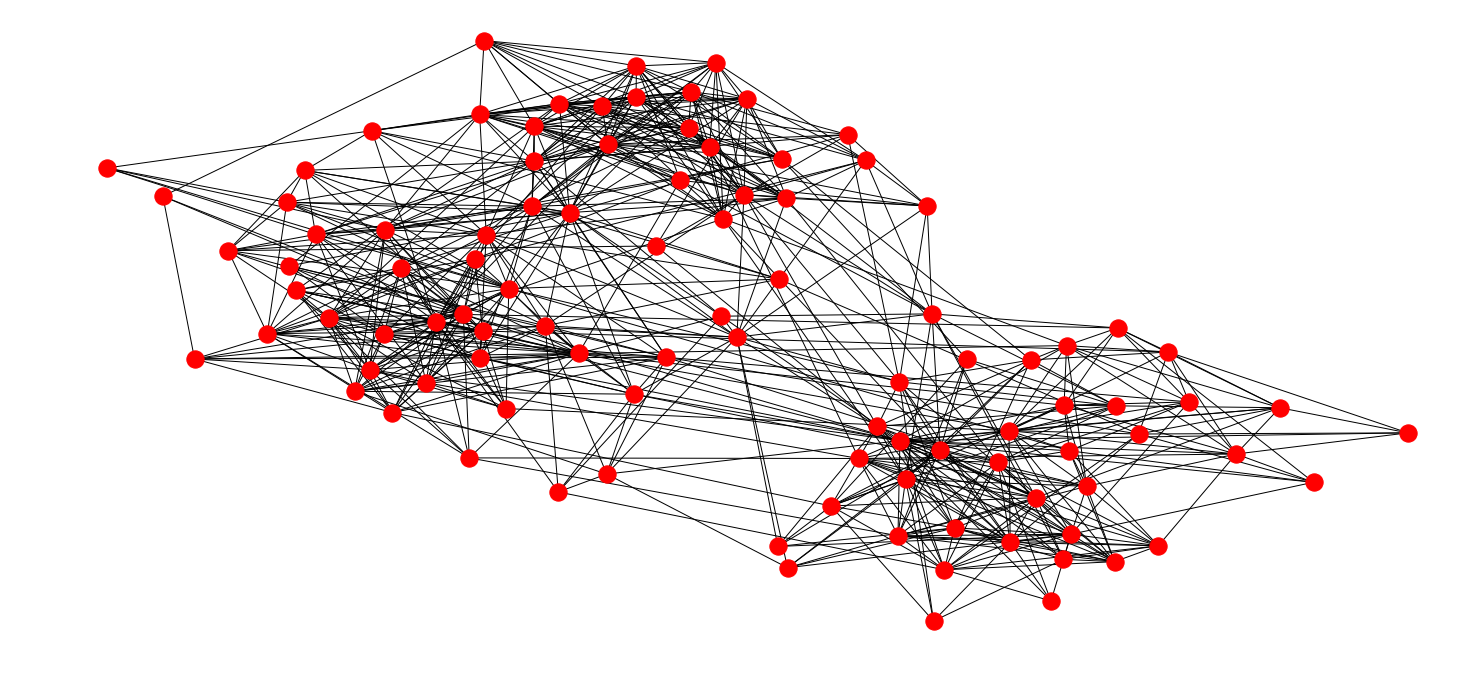

In [37]:
nx.draw(x.G)

In [38]:
x.run_model(500)

0
1
2
news preference 0.13355781781290893
3
4
5
6
7
8
9
10
11
12
13
14
news preference -0.6950042987621178
15
16
17
news preference -0.05865952809622951
18
19
20
21
22
23
24
news preference -0.015369044844827772
25
26
27
news preference 0.33164033191522135
28
29
30
news preference -0.015369044844827772
31
32
33
news preference -0.6950042987621178
34
35
36
37
38
39
news preference 0.02966122196658429
40
41
42
news preference -0.3472090375330235
43
44
45
news preference 0.16072326422552627
46
47
48
news preference 0.2538282801105188
49
50
51
news preference -0.3352027624429048
52
53
54
news preference 0.09028496793094025
55
56
57
58
news preference 0.009430607019576497
59
60
61
news preference -0.012890622663963996
62
63
64
news preference 0.031966754084549985
65
66
67
news preference 0.2644869933582896
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
news preference 0.2644869933582896
91
92
93
news preference 0.3335362248829142
94
95
96
news preference 0.134184172889

In [45]:
df = x.datacollector.get_model_vars_dataframe()

In [46]:
len(df['Source'].unique())

76

In [47]:
df

,Spammer,Neutral,Shares,Source,Fake
0,1,99,0,63,0
1,1,99,1,63,0
2,1,99,1,63,0
3,1,99,1,63,0
4,5,95,5,26,1
5,10,90,10,26,1
6,18,82,18,26,1
7,34,66,34,26,1
8,58,42,58,26,1
9,81,19,81,26,1


In [42]:
# df.to_csv('simulation_data.csv')

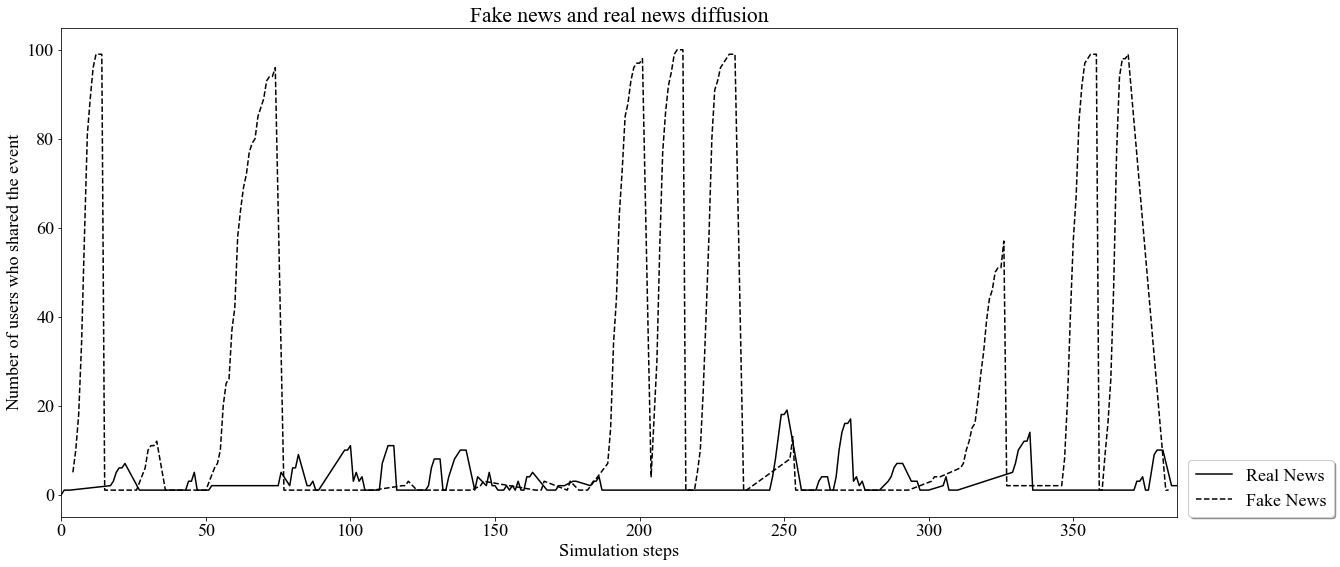

In [110]:
colors = {1:'r',0:'g'}
linestyles = {1:'--',0:'-'}

res = df[['Shares','Fake']]
_, ax = plt.subplots()


for n,g in res.groupby('Fake'):
    g['Shares'].plot(ax=ax, color='black',linestyle=linestyles[n])
    plt.rcParams["figure.figsize"] = [20,9]

ax.set_ylabel('Number of users who shared the event')
ax.set_xlabel('Simulation steps')
ax.set_title('Fake news and real news diffusion')

L = ax.legend(loc=(1.01,0),fancybox=True,shadow=True,frameon=True)
L.get_texts()[0].set_text('Real News')
L.get_texts()[1].set_text('Fake News')

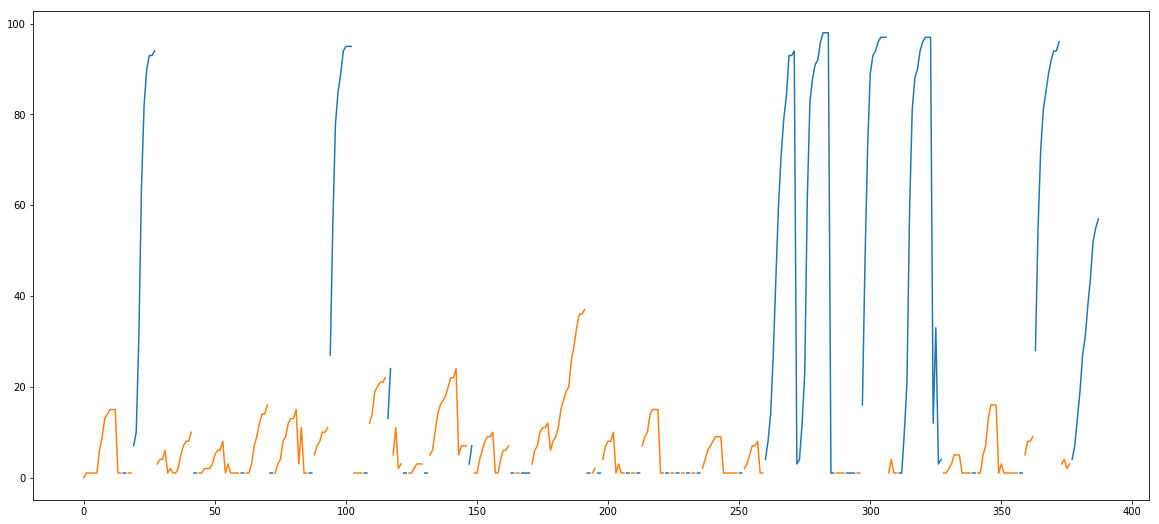

In [25]:
res = x.datacollector.get_model_vars_dataframe()[['Shares','Fake']]

t = np.arange(0,len(res),1)

s = res['Shares'].to_numpy()

f = res['Fake'].to_numpy()

threshold = 0.5

fupper=np.ma.masked_where(f > threshold, s)

flower=np.ma.masked_where(f < threshold, s)

fig, ax = plt.subplots()
ax.plot(t,flower,t,fupper)
plt.rcParams["figure.figsize"] = [20,9]
plt.show()

<Figure size 1440x648 with 0 Axes>

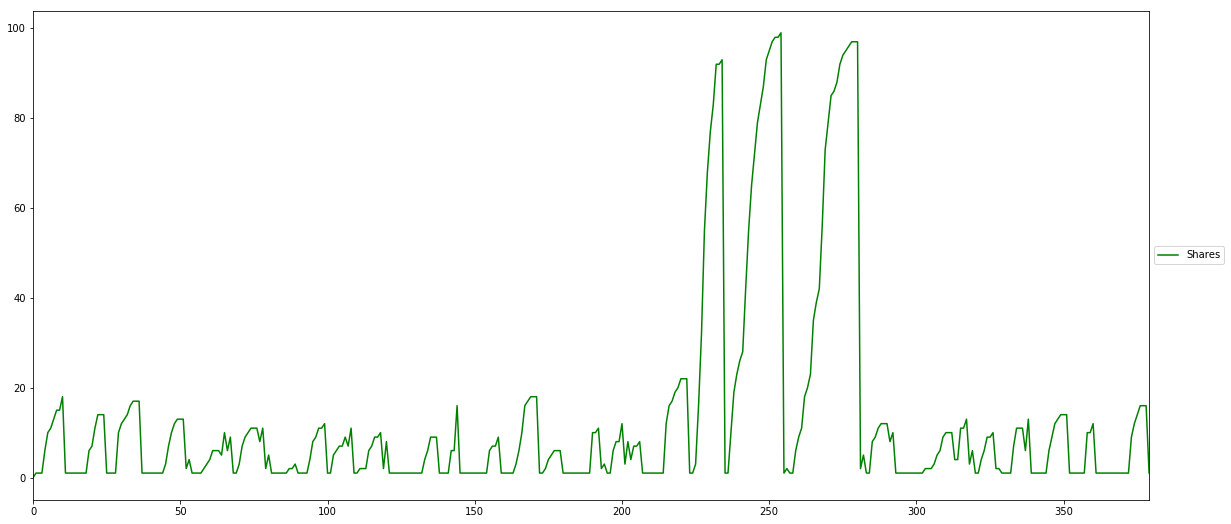

In [82]:
colors = {1:'r',0:'g'}

res = x.datacollector.get_model_vars_dataframe()[['Shares','Fake']]
res['Color'] = res['Fake'].map(colors)
colors = res['Color'].tolist()

plt.figure()
ax = res[['Shares']].plot(color=colors)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams["figure.figsize"] = [20,9]
plt.show()
# plt.savefig("results.jpg")

(array([ 6., 22., 12.,  1.,  1.,  0.,  0., 15., 31., 12.]),
 array([-0.78 , -0.628, -0.476, -0.324, -0.172, -0.02 ,  0.132,  0.284,
         0.436,  0.588,  0.74 ]),
 <a list of 10 Patch objects>)

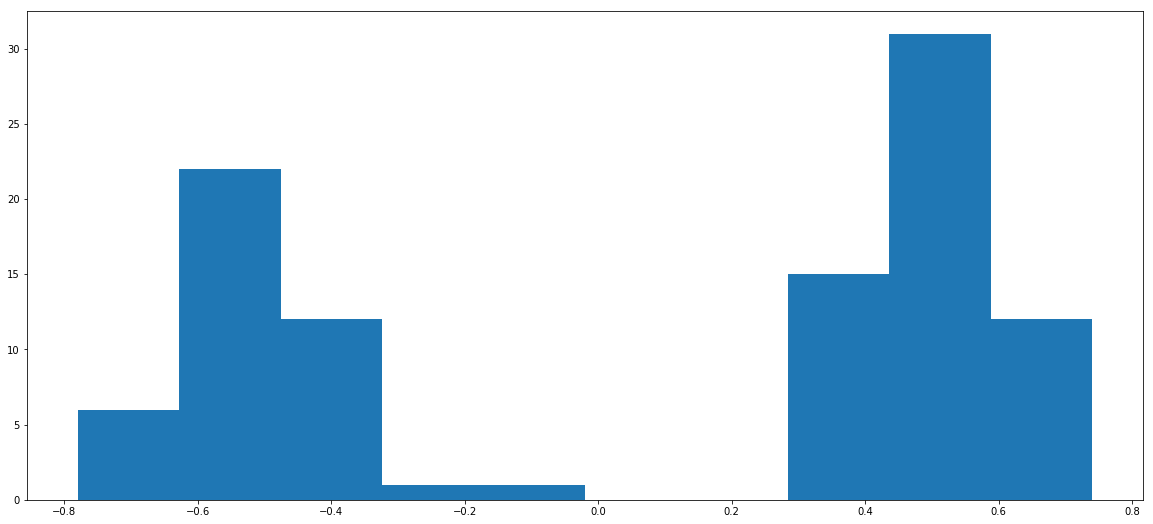

In [70]:
l = []
for i in x.schedule.agents:
    l.append(i.preference)
plt.hist(l)

In [ ]:
plt.hist([x.schedule.agents[i].preference for i in range(len(x.schedule.agents))])